In [1]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [101]:
#from sklearn.model_selection import train_test_split
#data_all = pd.read_csv('data/alturas-pesos-mils.csv')
#data, test = train_test_split(data_all, test_size=0.2)
#print(data)

In [102]:
data = pd.read_csv('data/alturas-pesos-mils-train.csv')

In [103]:
test = pd.read_csv('data/alturas-pesos-mils-test.csv')

In [491]:
class BiVariateJoint:
    def __init__(self, data, step_X = 1, step_Y = 1, mins=None, maxs=None):
        # Data tienen que ser un np.array de dos columnas
        self.step_X = step_X
        self.step_Y = step_Y
        step = np.array([step_X, step_Y])
        self.data = data
        self.data_rounded = (np.round(data/step)*step)
        if maxs is None:
            self.maxs = np.max(self.data_rounded, axis = 0)
        else:
            self.maxs = maxs
        if mins is None:
            self.mins = np.min(self.data_rounded, axis = 0)
        else:
            self.mins = mins
        tuples = [tuple(row) for row in self.data_rounded]
        self.frequencies = Counter(tuples)
        self.X = np.linspace(self.mins[0], self.maxs[0], int((self.maxs[0] - self.mins[0])/step_X + 1))
        self.Y = np.linspace(self.mins[1], self.maxs[1], int((self.maxs[1] - self.mins[1])/step_Y + 1))
        self.joint_matrix = self.freq_2_matrix()
        self.N = len(data)
    
    def plot_data(self, color='b'):
        plt.scatter(self.data[:,0], self.data[:,1], color=color, s=2)
    
    def plot_rounded(self, color='b'):
        plt.scatter(self.data_rounded[:,0], self.data_rounded[:,1], color=color, s=2)
    
    def get_prob(self, x, y, normalized=True):
        x = np.floor(np.round(x - self.X[0])/self.step_X).astype(int)
        y = np.floor(np.round(y - self.Y[0])/self.step_Y).astype(int)
        if normalized:
            prob = self.joint_matrix[x , y]/self.N
        else:
            prob = self.joint_matrix[x , y]
        return prob
    
    def freq_2_matrix(self):
        joint = np.zeros([len(self.X), len(self.Y)])
        for index, frec in self.frequencies.items():
            x = (index[0] - self.X[0])/self.step_X
            y = (index[1] - self.Y[0])/self.step_Y
            joint[int(x), int(y)] = frec
        return joint
    
    def get_Marginals(self):
        return self.joint_matrix.sum(axis=1), self.joint_matrix.sum(axis=0)
    
    def plot_joint_3d(self, az=50, el=-5, ax=None, color='b'):
        xpos, ypos = np.meshgrid(self.X, self.Y)
        xpos = xpos.T.flatten()
        ypos = ypos.T.flatten()
        zpos = np.zeros(xpos.shape)
        dx = self.step_X * np.ones_like(zpos)
        dy = self.step_Y * np.ones_like(zpos)
        dz = self.joint_matrix.astype(int).flatten()
        if ax == None:
            fig = plt.figure(figsize=(20,20))
            ax = fig.add_subplot(111, projection='3d')
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=color, alpha=0.5)
        ax.view_init(az, el)

In [420]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values

In [515]:
maxs = np.round(data[['Peso','Altura']].values.max(axis = 0))
mins = np.round(data[['Peso','Altura']].values.min(axis = 0))
step = 8

In [516]:
joint_hombres = BiVariateJoint(data_hombres, 
                               step_X = step, 
                               step_Y = step,
                               mins = mins, 
                               maxs = maxs
                              )
joint_mujeres = BiVariateJoint(data_mujeres, 
                               step_X = step, 
                               step_Y = step,
                               mins = mins, 
                               maxs = maxs)

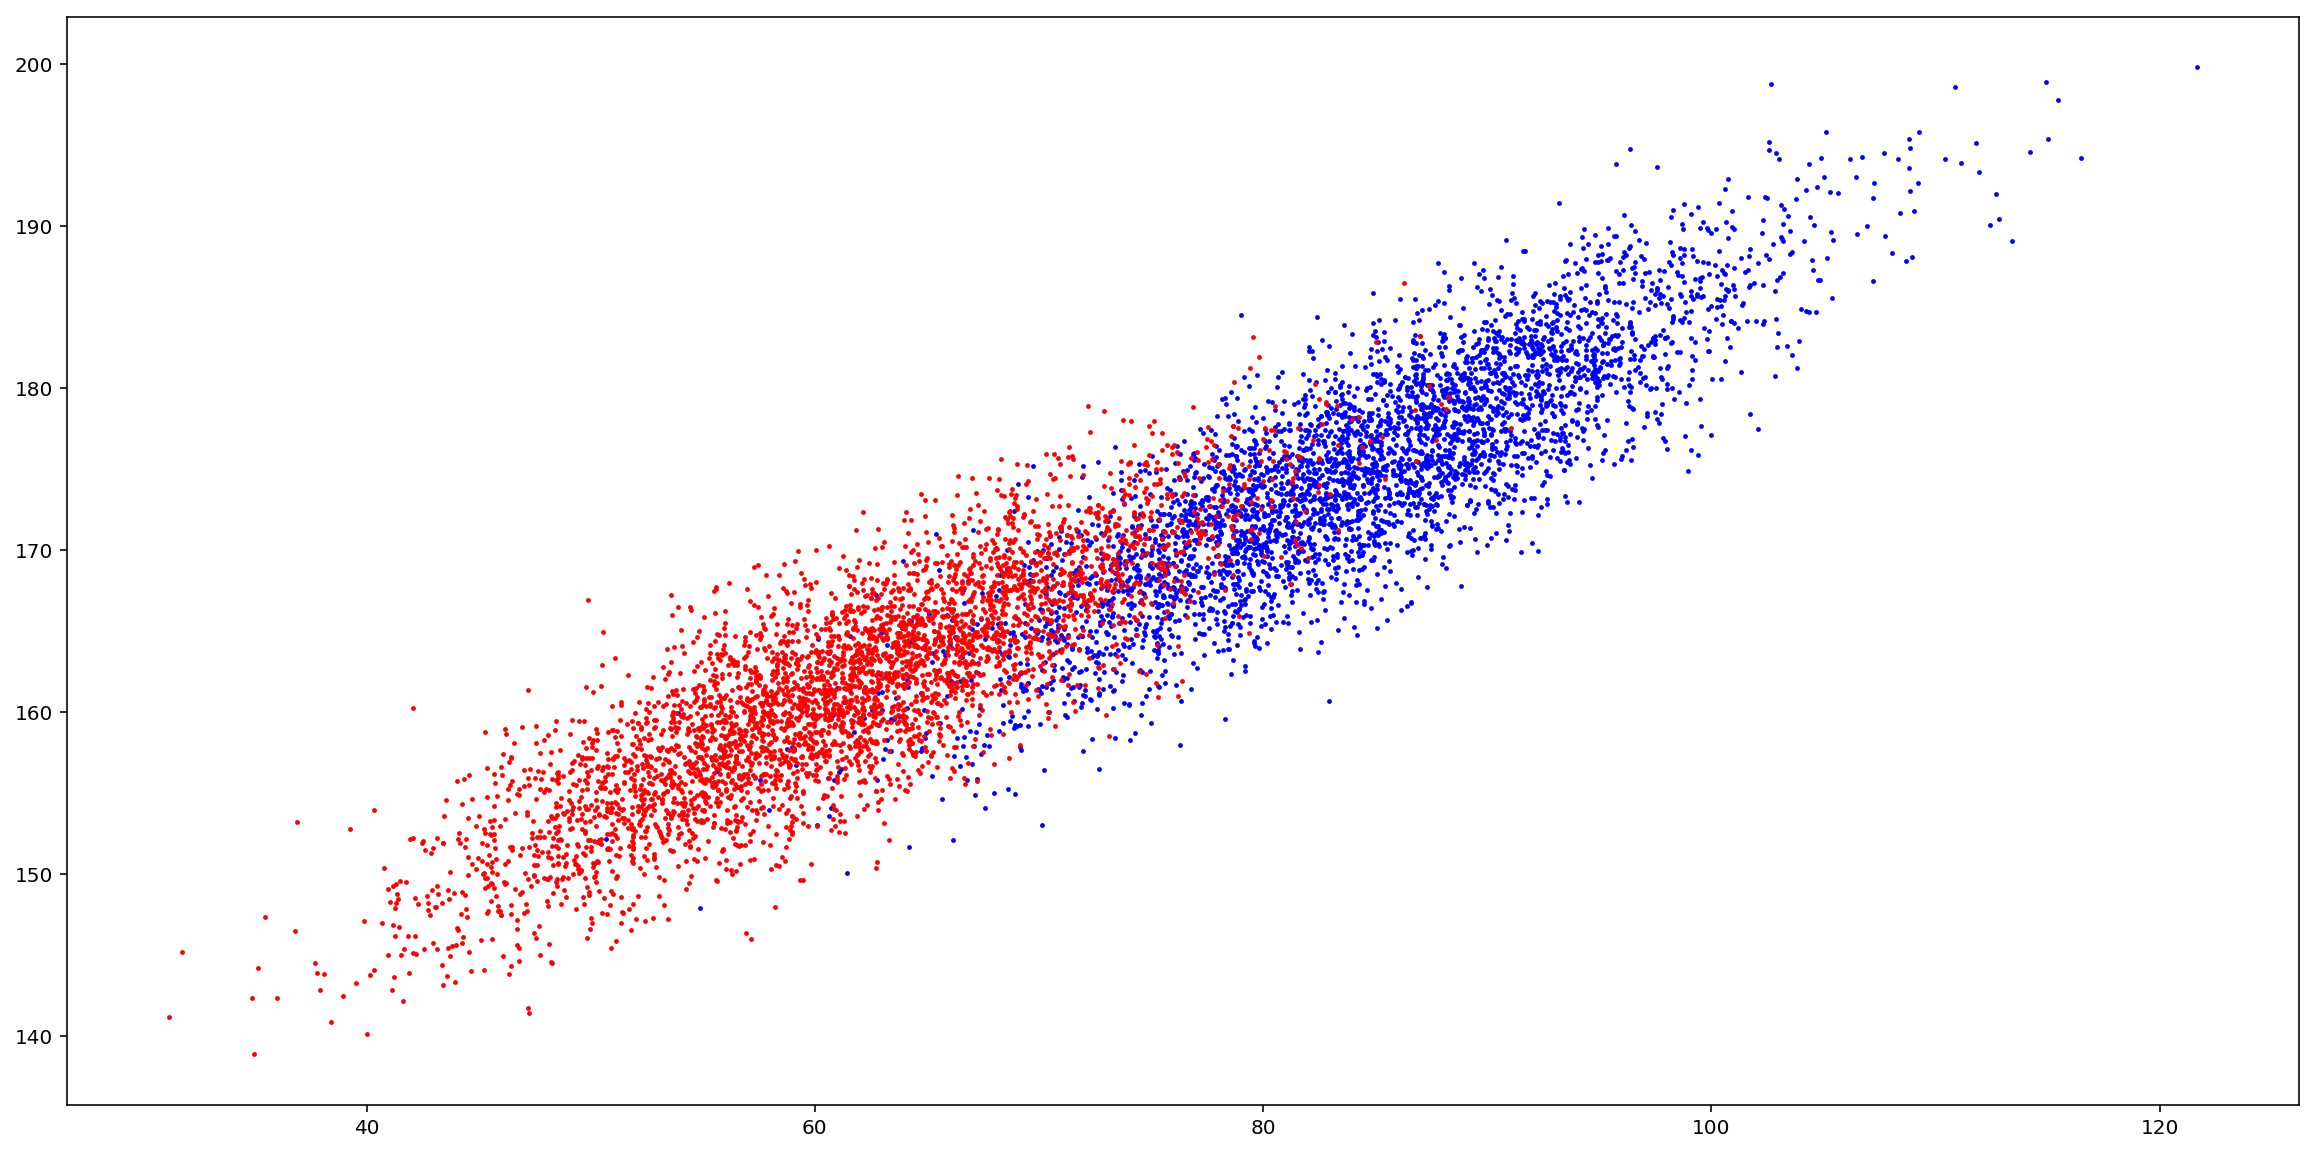

In [517]:
f = plt.figure(figsize=(20,10))
joint_hombres.plot_data(color='b')
joint_mujeres.plot_data(color='r')

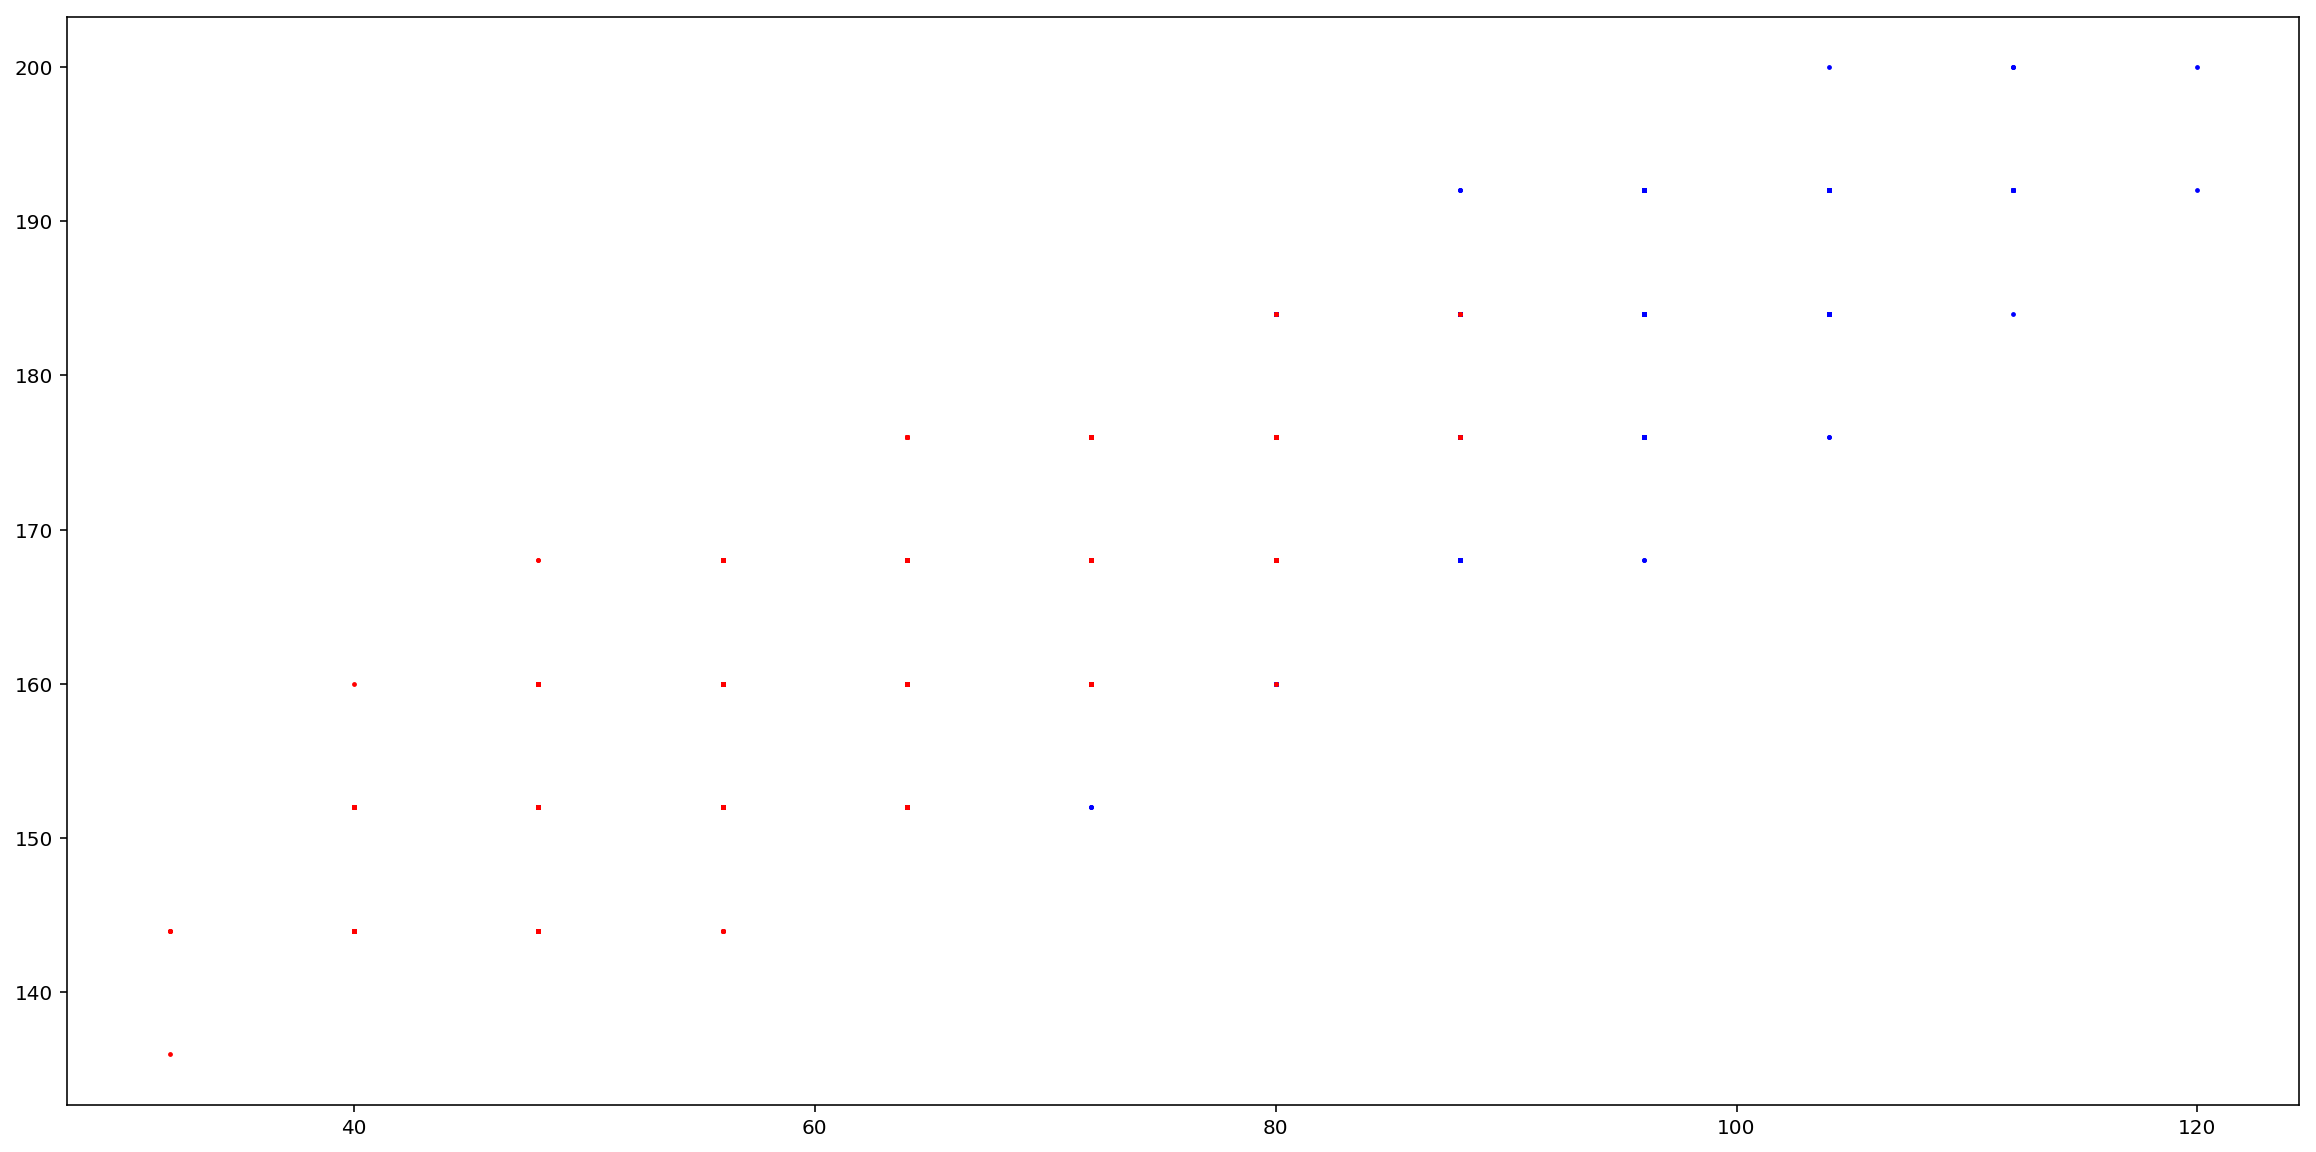

In [518]:
f = plt.figure(figsize=(20,10))
joint_hombres.plot_rounded(color='b')
joint_mujeres.plot_rounded(color='r')

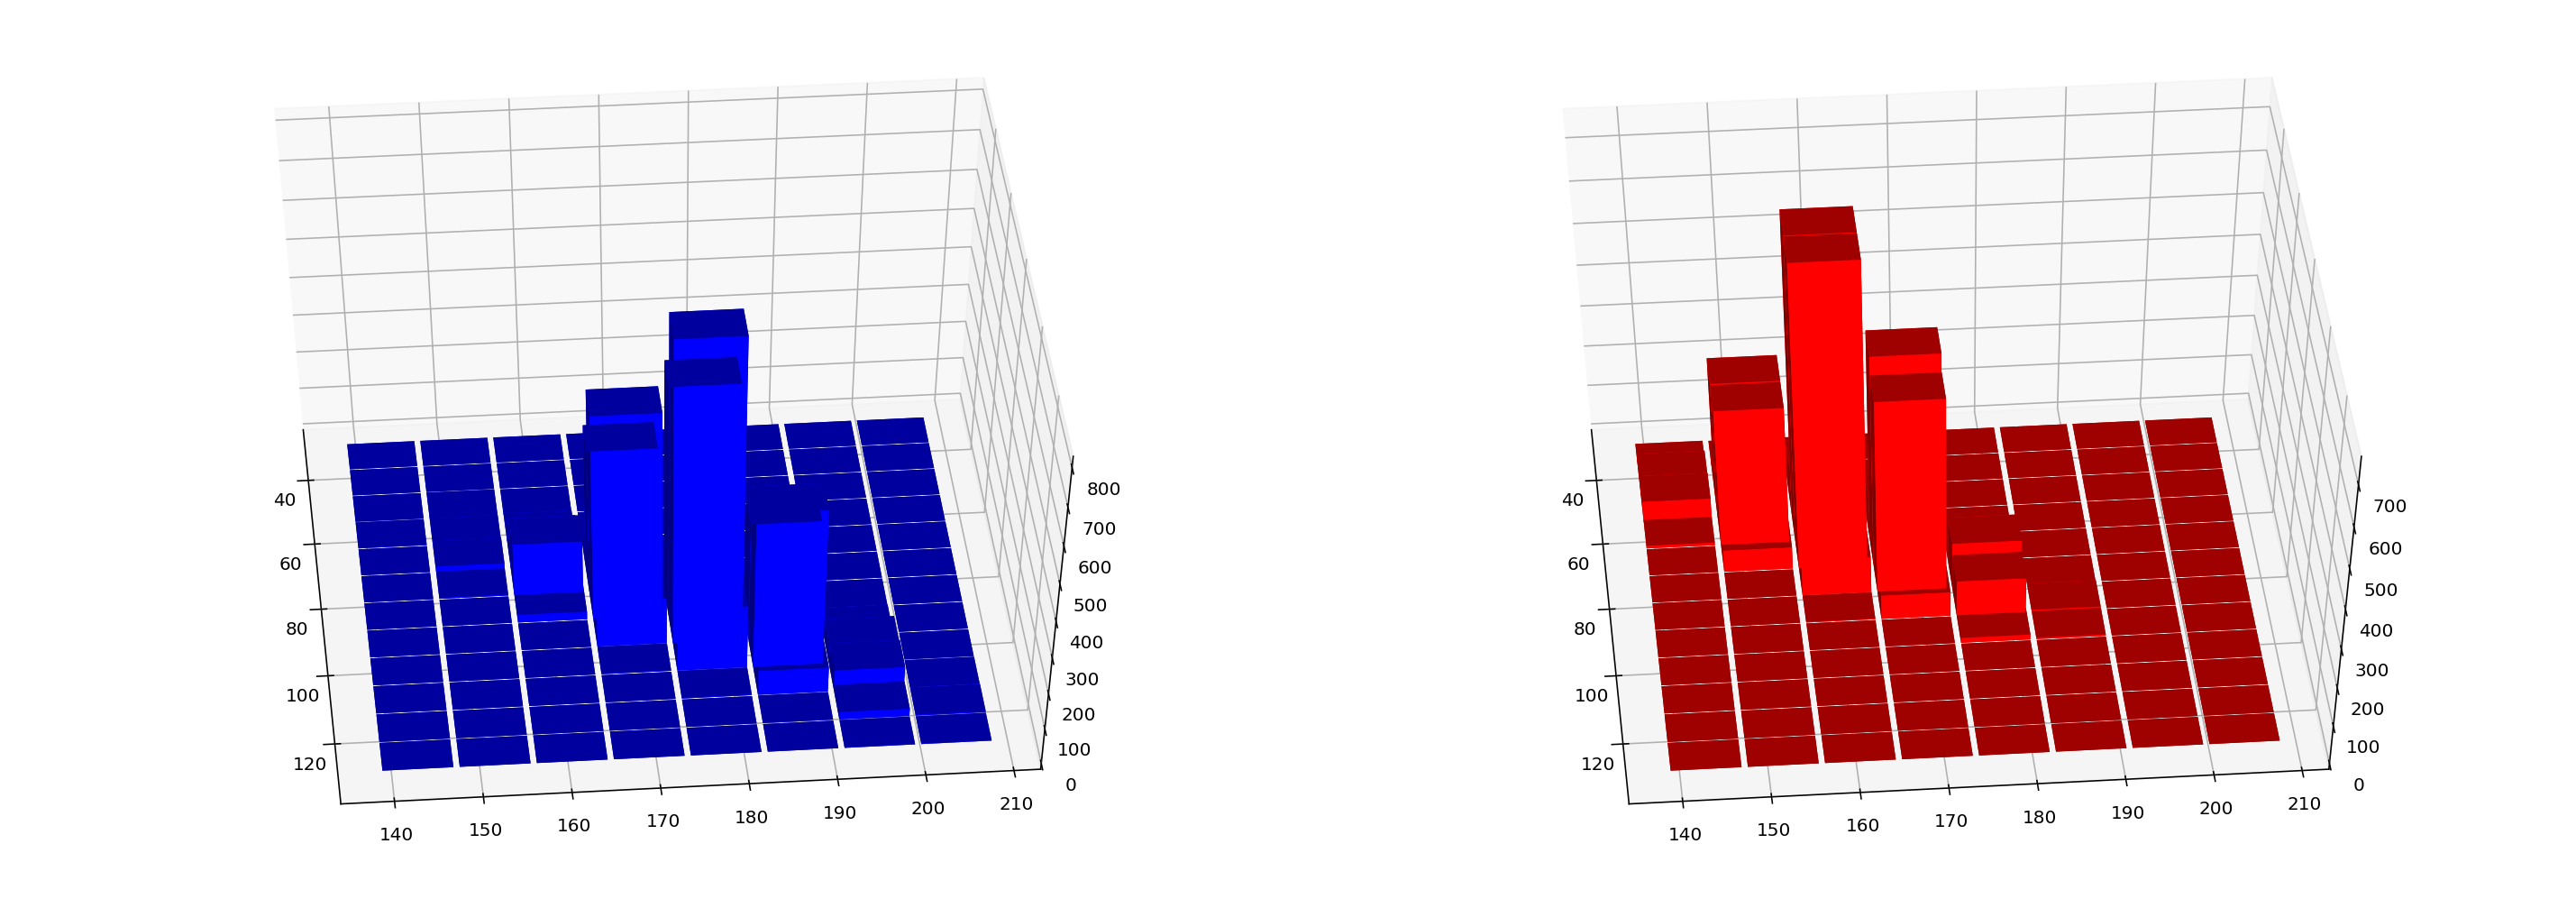

In [519]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
joint_hombres.plot_joint_3d(ax=ax1, color='b')
joint_mujeres.plot_joint_3d(ax=ax2, color='r')
fig.tight_layout()

# Bayes

\begin{equation}
P(Hombre | X_1, X_2) = \frac{P(X_1,X_2 | Hombre) P(Hombre)}{P(X_1,X_2)} \\
P(Mujer | X_1, X_2) = \frac{P(X_1,X_2 | Mujer) P(Mujer)}{P(X_1,X_2)}
\end{equation}

In [520]:
def get_class_prob_old(frec_class_1, frec_class_2, p, a):
    cant_class_1 = np.array(list(frec_class_1.values())).sum()
    cant_class_2 = np.array(list(frec_class_2.values())).sum()
    prior_class_1 = cant_class_1/(cant_class_1 + cant_class_2)
    prior_class_2 = cant_class_2/(cant_class_1 + cant_class_2)
    likelihood_class_1 = frec_class_1[(p, a)]/cant_class_1
    likelihood_class_2 = frec_class_2[(p, a)]/cant_class_2
    #print(likelihood_class_1, likelihood_class_2)
    total = (frec_class_1[(p, a)] + frec_class_2[(p, a)])/(cant_class_1 + cant_class_2)
    # Si es cero da igual el resultado
    if total==0:
        return 0.5, 0.5
    p_class_1 = prior_class_1*likelihood_class_1/total
    p_class_2 = prior_class_2*likelihood_class_2/total
    return p_class_1, p_class_2

In [521]:
def get_class_prob(x_data, y_data):
    prior_class_1 = joint_hombres.N/ (joint_hombres.N + joint_mujeres.N)
    prior_class_2 = joint_mujeres.N/ (joint_hombres.N + joint_mujeres.N)
    likelihood_class_1 = joint_hombres.get_prob(x_data, y_data)
    likelihood_class_2 = joint_mujeres.get_prob(x_data, y_data)
    total = likelihood_class_1*prior_class_1 + prior_class_2*likelihood_class_2
    # Evita division por cero
    total[total==0] = 1
    p_class_1 = prior_class_1*likelihood_class_1/total
    p_class_2 = prior_class_2*likelihood_class_2/total
    # Las indeterminadas en 0.5
    p_class_1[total==1] = 0.5
    p_class_2[total==1] = 0.5
    return p_class_1, p_class_2

In [522]:
p_class_1, p_class_2 = get_class_prob(data['Peso'].values, data['Altura'].values)
((p_class_1>p_class_2) == (data['Genero'].values == 'Hombre')).sum()/len(data)

0.867125

In [523]:
p_class_1, p_class_2 = get_class_prob(test['Peso'].values, test['Altura'].values)
((p_class_1>p_class_2) == (test['Genero'].values == 'Hombre')).sum()/len(test)

0.864

In [524]:
def get_accuracy(data, frecuencias_hombres, frecuencias_mujeres):
    classifier_eval = []
    for i, row in data.iterrows():
        p_1, p_2 = get_class_prob_old(frecuencias_hombres, 
                                  frecuencias_mujeres, 
                                  int(np.round(row['Peso'])), 
                                  int(np.round(row['Altura'])))
        classifier_eval.append((p_1>p_2) == (row['Genero'] == 'Hombre'))
    return classifier_eval, np.array(classifier_eval).sum()/len(data)

In [525]:
%time _, acc = get_accuracy(data, joint_hombres.frequencies, joint_mujeres.frequencies)
print(acc)

CPU times: user 1.15 s, sys: 7.66 ms, total: 1.15 s
Wall time: 1.16 s
0.505625


In [526]:
_, acc = get_accuracy(test, joint_hombres.frequencies, joint_mujeres.frequencies)
print(acc)

0.5065


In [527]:
X, Y = np.meshgrid(joint_hombres.X, joint_hombres.Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = np.zeros(pos.shape[:2])
for i, row in enumerate(pos):
    for j, col in enumerate(row):
        prob, _ = get_class_prob_old(joint_hombres.frequencies, joint_mujeres.frequencies, col[0], col[1])
        #if prob==0:
        #    print(col[0], col[1])
        Z[i, j] = prob

In [528]:
X, Y = np.meshgrid(joint_hombres.X, joint_hombres.Y)
Z = np.zeros(pos.shape[:2])
for i in range(X.shape[0]):
    Z[i] = get_class_prob(X[i], Y[i])[0]

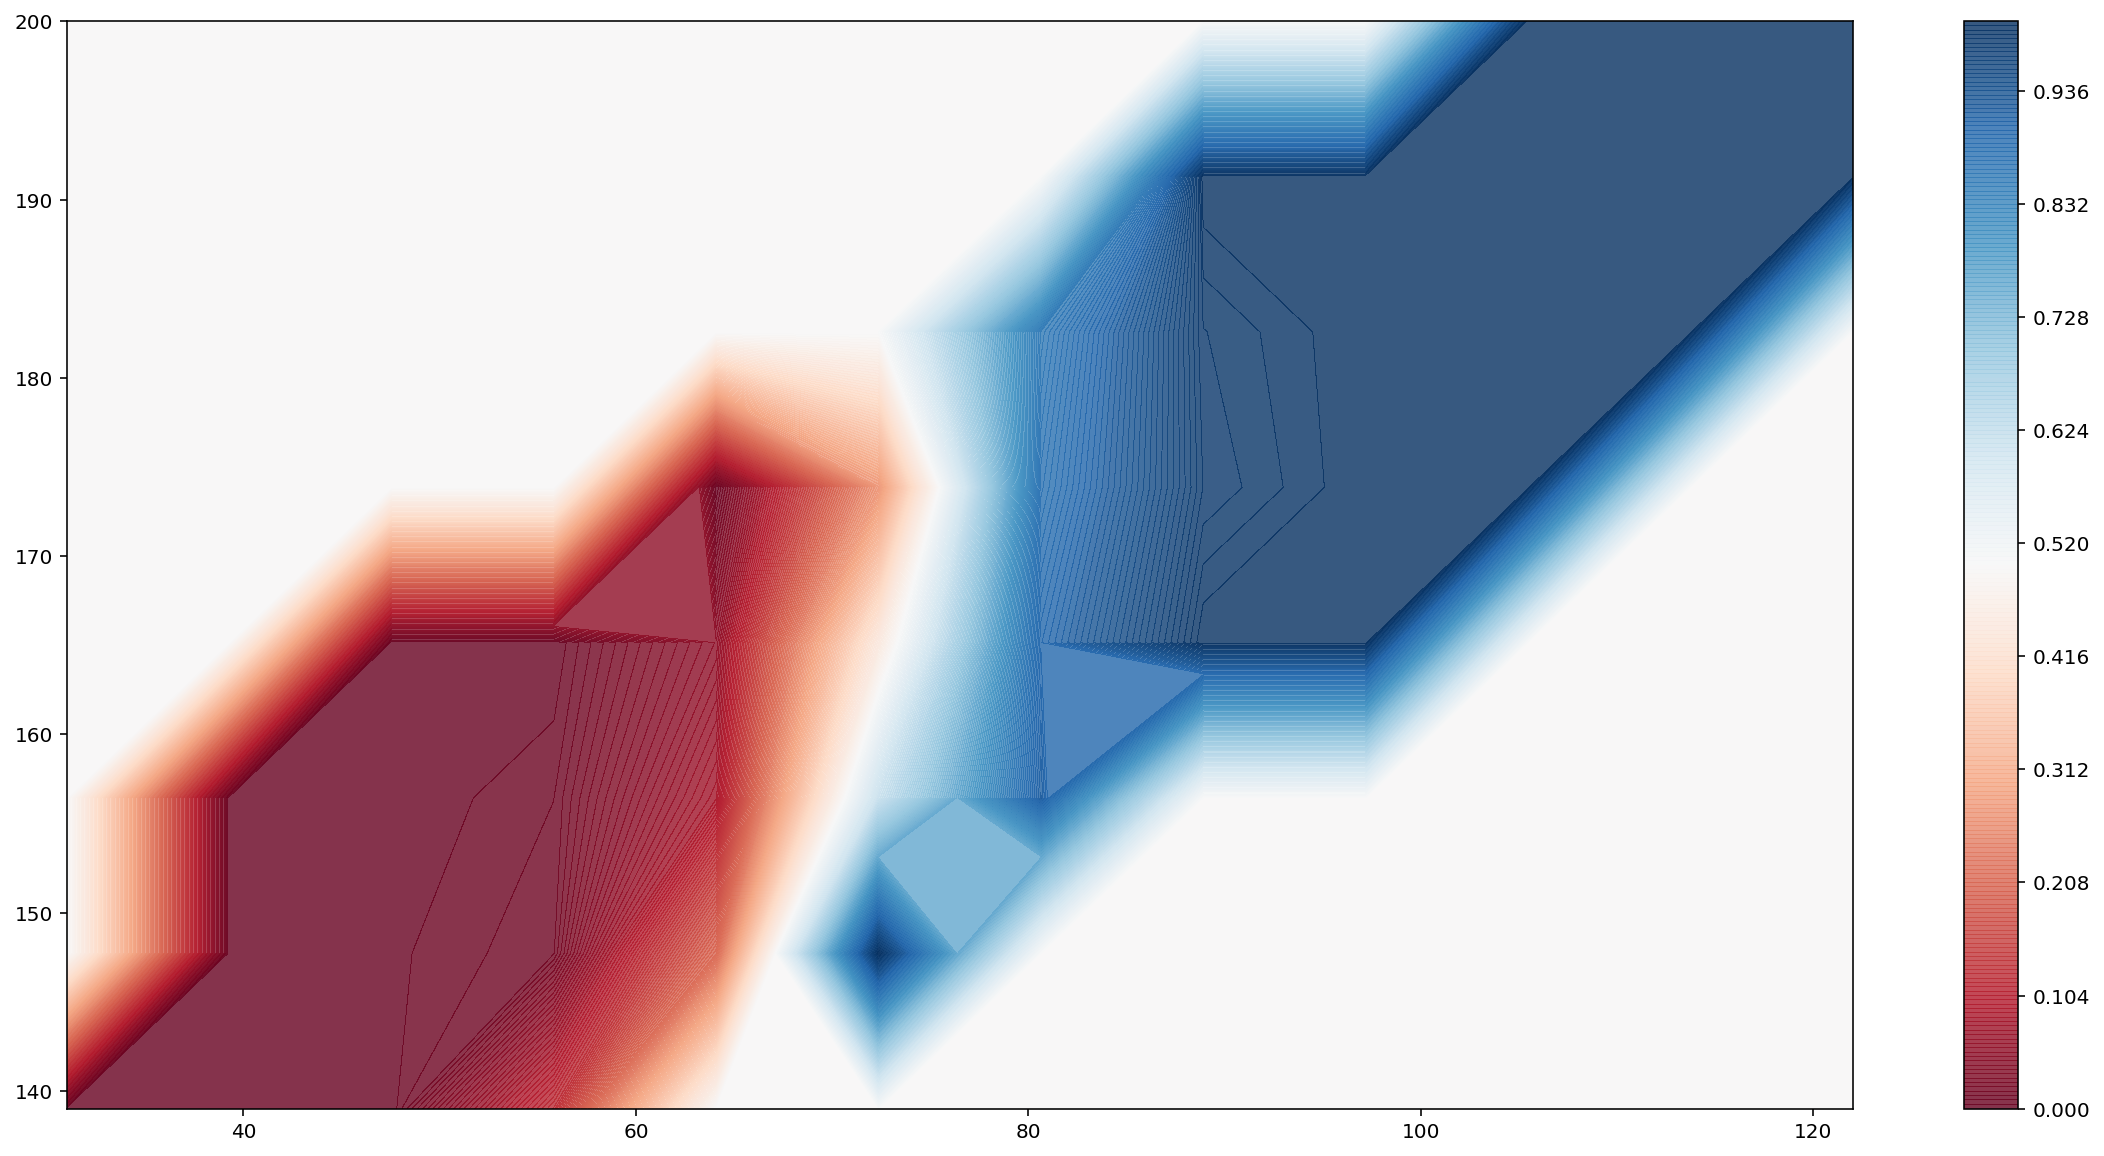

In [529]:
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
plt.show()

## Naive Bayes (Supongo independencia)

In [532]:
marg_pesos_hombres,  marg_alturas_hombres = joint_hombres.get_Marginals()
marg_pesos_mujeres,  marg_alturas_mujeres = joint_mujeres.get_Marginals()

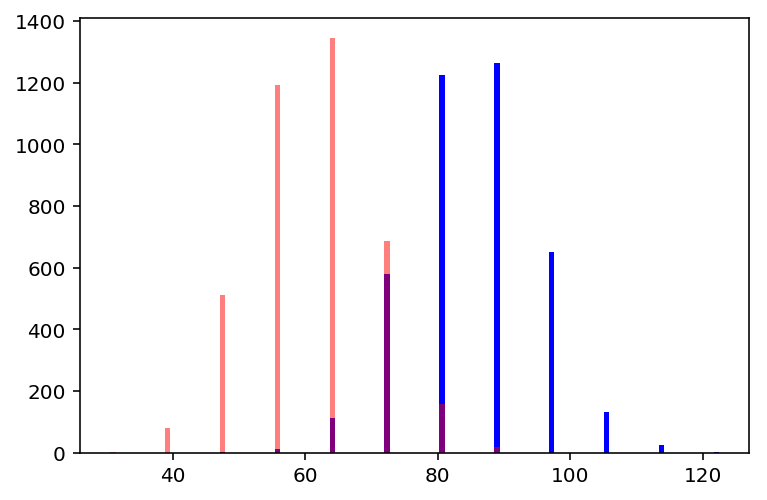

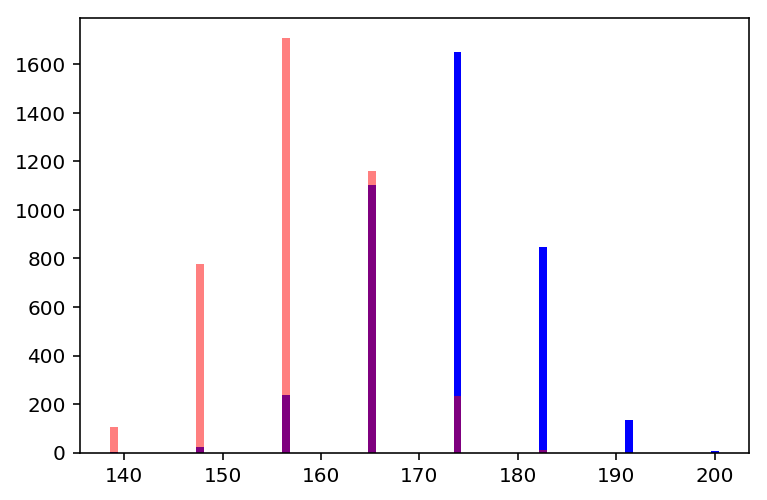

In [533]:
%matplotlib inline
plt.bar(joint_hombres.X, marg_pesos_hombres, color='b')
plt.bar(joint_mujeres.X, marg_pesos_mujeres, alpha=0.5, color='r')
plt.show()
plt.bar(joint_hombres.Y, marg_alturas_hombres, color='b')
plt.bar(joint_mujeres.Y, marg_alturas_mujeres, alpha=0.5, color='r')
plt.show()

In [534]:
marg_pesos_hombres_rep, marg_alturas_hombres_rep = np.meshgrid(marg_pesos_hombres, marg_alturas_hombres)
marg_pesos_mujeres_rep, marg_alturas_mujeres_rep = np.meshgrid(marg_pesos_mujeres, marg_alturas_mujeres)

In [535]:
marg_pesos_hombres_rep = np.repeat(marg_pesos_hombres.reshape(-1,1), len(marg_alturas_hombres), axis=1)
marg_alturas_hombres_rep = np.repeat(marg_alturas_hombres.reshape(-1,1), len(marg_pesos_hombres), axis=1).T
marg_pesos_mujeres_rep = np.repeat(marg_pesos_mujeres.reshape(-1,1), len(marg_alturas_mujeres), axis=1)
marg_alturas_mujeres_rep = np.repeat(marg_alturas_mujeres.reshape(-1,1), len(marg_pesos_mujeres), axis=1).T

In [536]:
conj_indep_hombres = marg_pesos_hombres_rep*marg_alturas_hombres_rep
conj_indep_mujeres = marg_pesos_mujeres_rep*marg_alturas_mujeres_rep

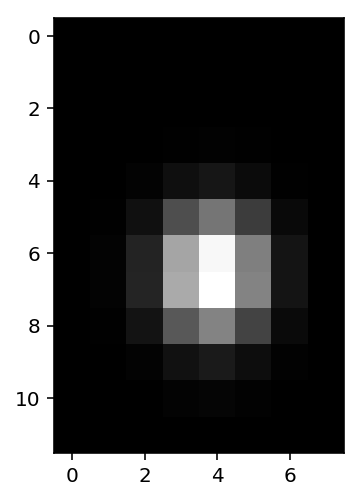

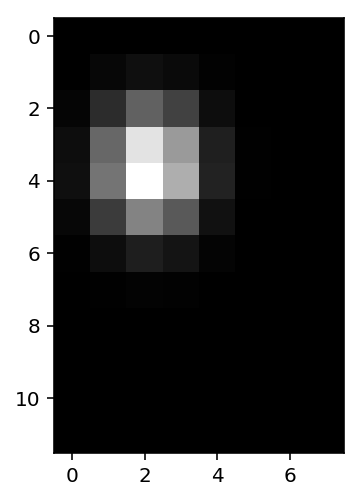

In [537]:
plt.imshow(conj_indep_hombres, cmap='gray')
plt.show()
plt.imshow(conj_indep_mujeres, cmap='gray')
plt.show()

\begin{equation}
P(Hombre | X_1, X_2) = \frac{P(X_1 | Hombre) P(X_2 | Hombre) P(Hombre)}{P(X_1,X_2)} \\
P(Mujer | X_1, X_2) = \frac{P(X_1 | Mujer) P(X_2 | Mujer) P(Mujer)}{P(X_1,X_2)}
\end{equation}

In [538]:
def get_Marginals(frecuencias):
    frecuencias_pesos = {}
    frecuencias_alturas = {}
    for (p,a), fr in frecuencias.items():
        if a not in frecuencias_alturas:
            frecuencias_alturas[a] = 0
        if p not in frecuencias_pesos:
            frecuencias_pesos[p] = 0
        frecuencias_pesos[p] = frecuencias_pesos[p] + fr
        frecuencias_alturas[a] = frecuencias_alturas[a] + fr
    return Counter(frecuencias_pesos), Counter(frecuencias_alturas)

In [539]:
def get_class_prob_naive(frec_class_1, frec_class_2, p, a):
    frecuencias_pesos_class_1, frecuencias_alturas_class_1 = get_Marginals(frec_class_1)
    frecuencias_pesos_class_2, frecuencias_alturas_class_2 = get_Marginals(frec_class_2)
    cant_class_1 = np.array(list(frec_class_1.values())).sum()
    cant_class_2 = np.array(list(frec_class_2.values())).sum()
    prior_class_1 = cant_class_1/(cant_class_1 + cant_class_2)
    prior_class_2 = cant_class_2/(cant_class_1 + cant_class_2)
    likelihood_class_1 = frecuencias_pesos_class_1[p]/cant_class_1 * frecuencias_alturas_class_1[a]/cant_class_1
    likelihood_class_2 = frecuencias_pesos_class_2[p]/cant_class_2 * frecuencias_alturas_class_2[a]/cant_class_2
    total = likelihood_class_1*prior_class_1 + likelihood_class_2*prior_class_2
    # Si es cero da igual el resultado
    if total==0:
        return 0.5, 0.5
    p_class_1 = prior_class_1*likelihood_class_1/total
    p_class_2 = prior_class_2*likelihood_class_2/total
    return p_class_1, p_class_2

In [540]:
def get_accuracy_naive(data, frecuencias_hombres, frecuencias_mujeres):
    classifier_eval = []
    for i, row in data.iterrows():
        p_1, p_2 = get_class_prob_naive(frecuencias_hombres, 
                                  frecuencias_mujeres, 
                                  int(np.round(row['Peso'])), 
                                  int(np.round(row['Altura'])))
        classifier_eval.append((p_1>p_2) == (row['Genero'] == 'Hombre'))
    return np.array(classifier_eval).sum()/len(data)

In [541]:
%time get_accuracy_naive(data, joint_hombres.frequencies, joint_mujeres.frequencies)

CPU times: user 1.73 s, sys: 10 ms, total: 1.74 s
Wall time: 1.74 s


0.5055

In [179]:
get_accuracy_naive(test, joint_hombres.frequencies, joint_mujeres.frequencies)

0.8845

In [182]:
X, Y = np.meshgrid(joint_hombres.X, joint_hombres.Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = np.zeros(pos.shape[:2])
for i, row in enumerate(pos):
    for j, col in enumerate(row):
        prob, _ = get_class_prob_naive(joint_hombres.frequencies, joint_mujeres.frequencies, col[0], col[1])
        Z[i, j] = prob

(62, 92)


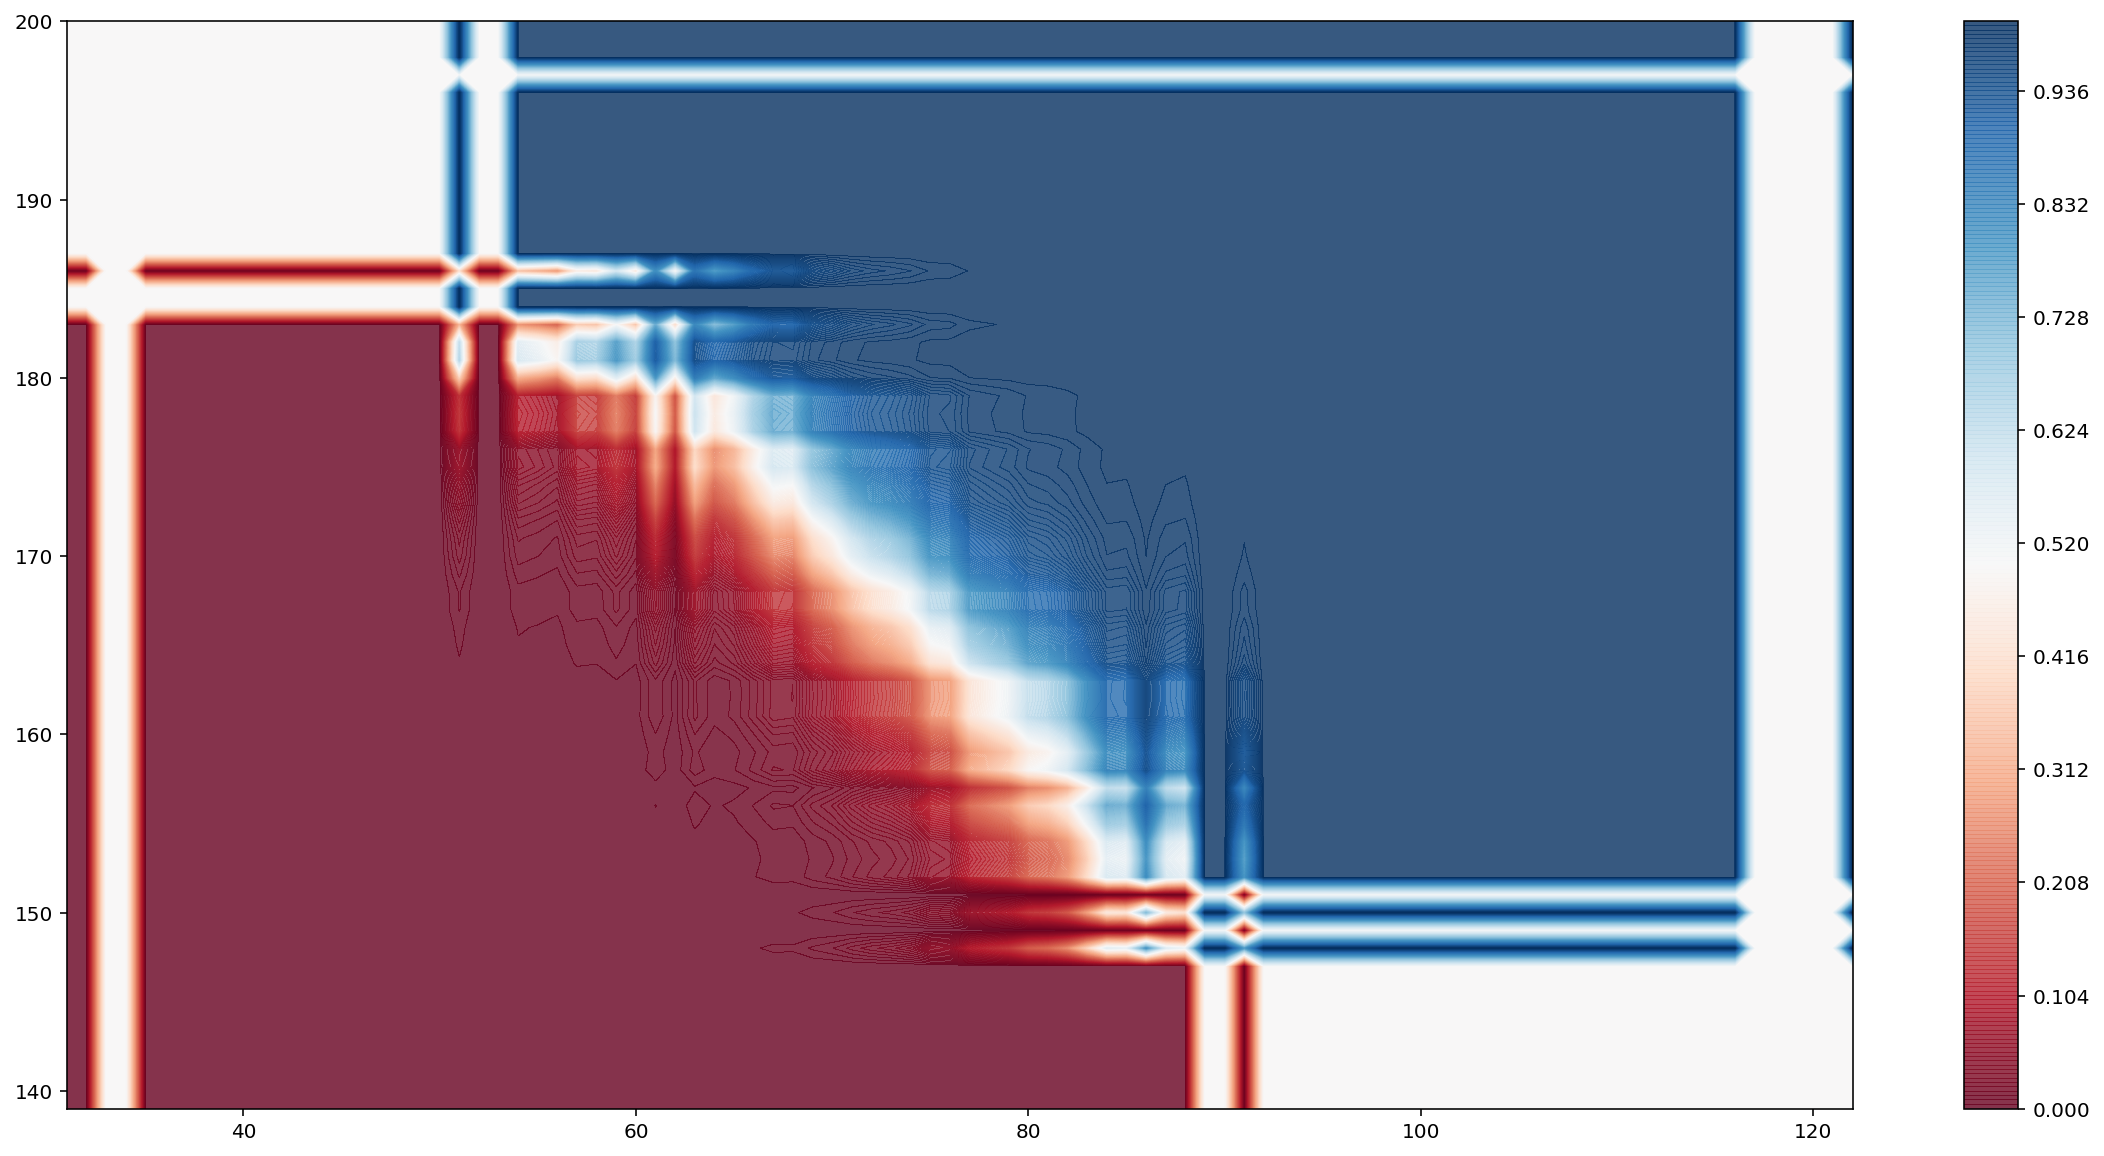

In [183]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
plt.show()

# Gaussiano

\begin{equation}
P(Hombre | X_1, X_2) = \frac{p(X_1,X_2 | Hombre) P(Hombre)}{p(X_1,X_2)} \\
P(Mujer | X_1, X_2) = \frac{p(X_1,X_2 | Mujer) P(Mujer)}{p(X_1,X_2)} \\
p(X_1,X_2) = p(X_1,X_2 | Hombre) P(Hombre) + p(X_1,X_2 | Mujer) P(Mujer)
\end{equation}

In [19]:
peso_altura_hombres = data.loc[data['Genero']=='Hombre'][['Peso', 'Altura']].values
peso_altura_mujeres = data.loc[data['Genero']=='Mujer'][['Peso', 'Altura']].values

In [20]:
mean_hombres = peso_altura_hombres.mean(axis=0)
mean_mujeres = peso_altura_mujeres.mean(axis=0)

In [21]:
cov_hombres = np.cov(peso_altura_hombres.T)
cov_mujeres = np.cov(peso_altura_mujeres.T)

In [22]:
from scipy.stats import multivariate_normal

In [23]:
def get_prob(data):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres)
    N_class_1 = len(peso_altura_hombres)
    N_class_2 = len(peso_altura_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

In [24]:
def get_acc_gauss(data):
    p_class_1, p_class_2 = get_prob(data[['Peso', 'Altura']].values)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(p_class_1)

In [25]:
%time get_acc_gauss(data)

CPU times: user 6.25 ms, sys: 1.75 ms, total: 7.99 ms
Wall time: 6.55 ms


0.91675

In [26]:
print(get_acc_gauss(test))

0.9225


In [27]:
N = 300
X, Y = np.meshgrid(joint_hombres.X, joint_hombres.Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z_H = multivariate_normal.pdf(pos, mean_hombres, cov_hombres)
Z_M = multivariate_normal.pdf(pos, mean_mujeres, cov_mujeres)
Z, _ = get_prob(pos)

In [31]:
%matplotlib qt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
#plt.colorbar(cf, ax=ax)
ax.contourf(X, Y, Z_H, 256)
ax.contourf(X, Y, Z_M, 256)
ax.view_init(70, -90)
plt.show()

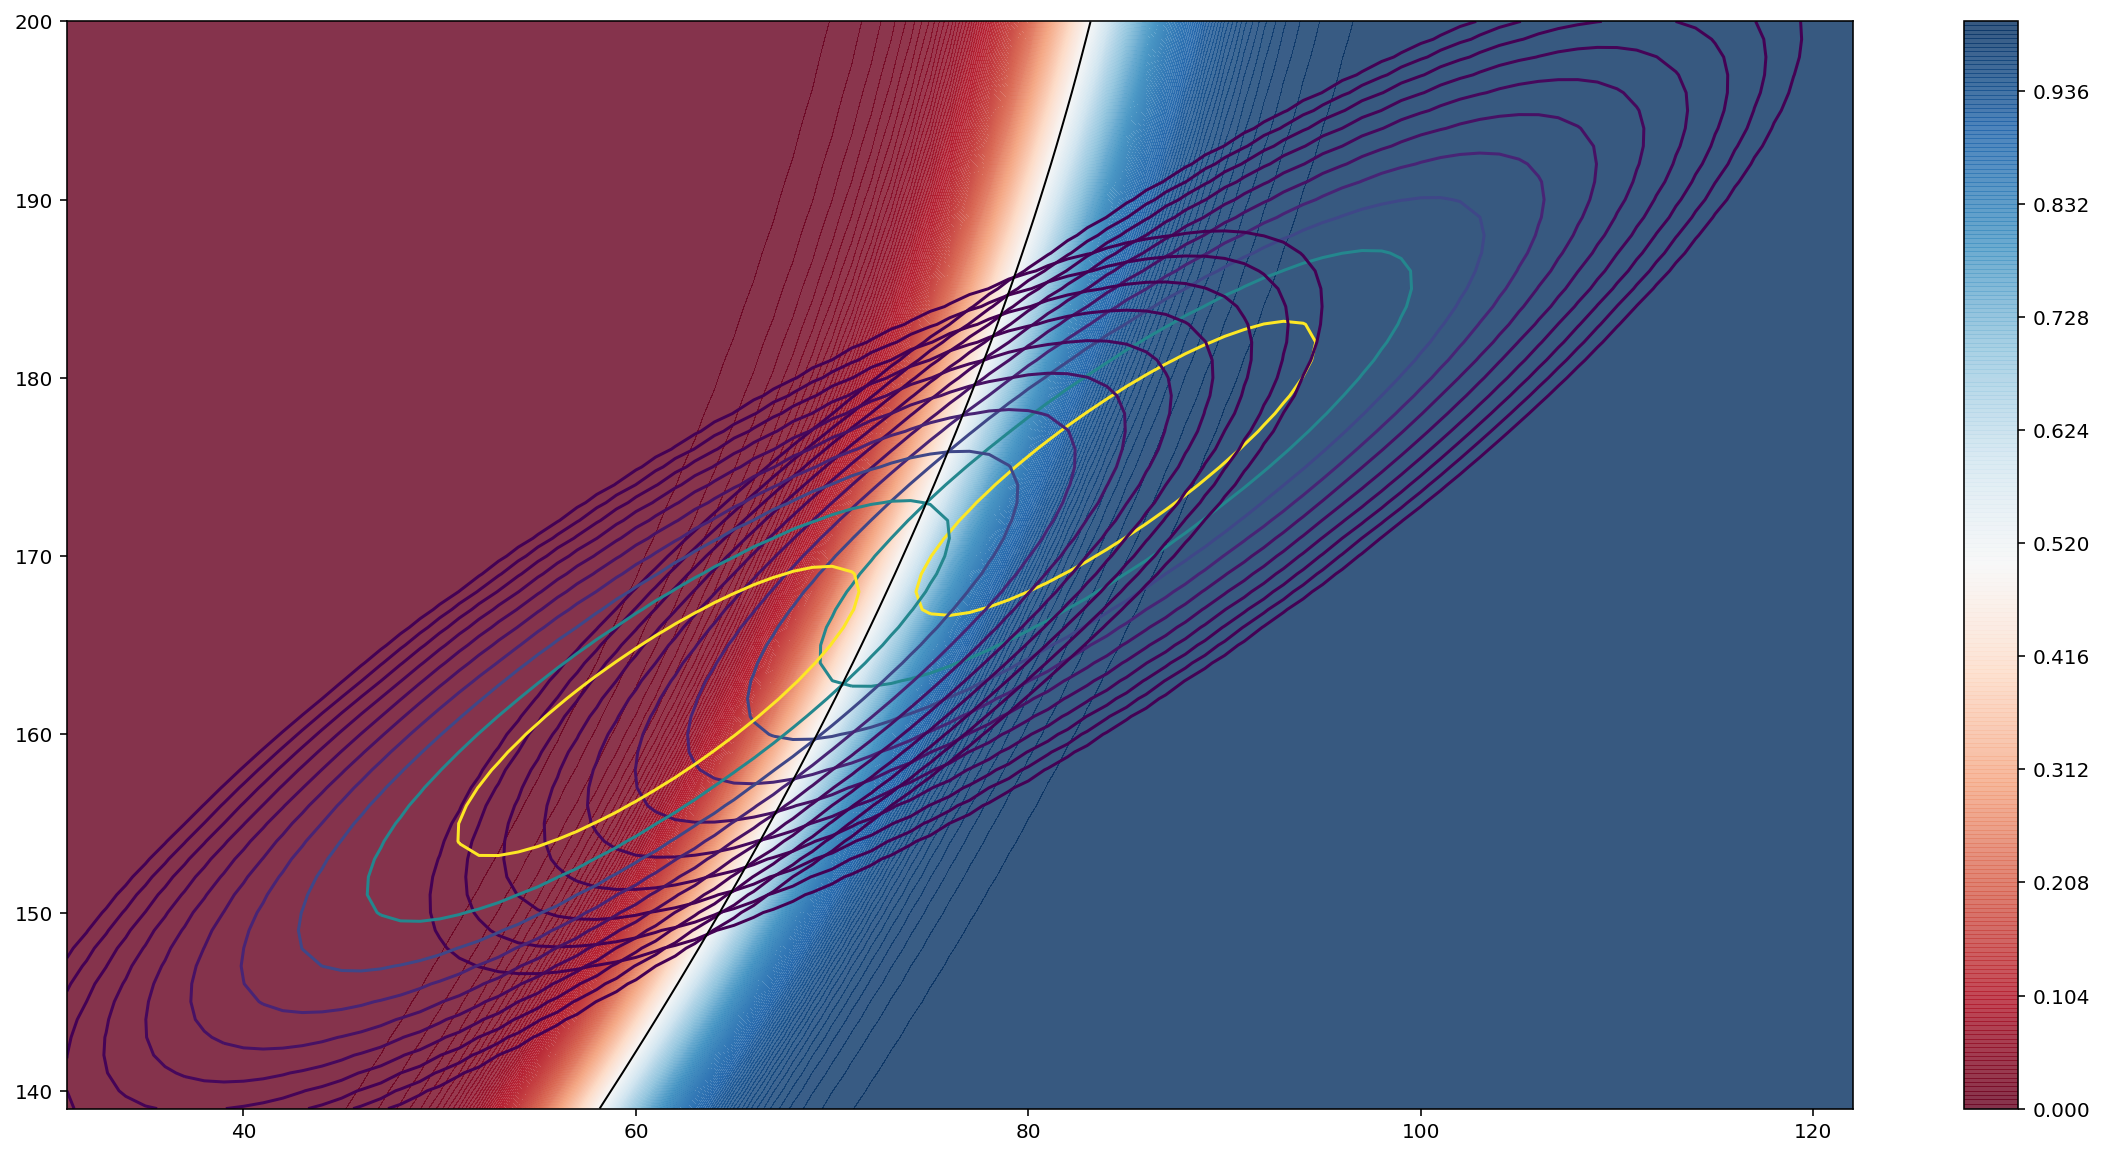

In [32]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,10)/4
ax.contour(X, Y, Z_H, z_levels)
ax.contour(X, Y, Z_M, z_levels)
ax.contour(X, Y, Z, (0.5,), colors='k', linewidths=1)
plt.show()

# Naive Bayes

In [33]:
cov_hombres*np.identity(2)

array([[80.69463867,  0.        ],
       [ 0.        , 53.02237224]])

In [34]:
def get_prob_naive(data):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres*np.identity(2))
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres*np.identity(2))
    N_class_1 = len(peso_altura_hombres)
    N_class_2 = len(peso_altura_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

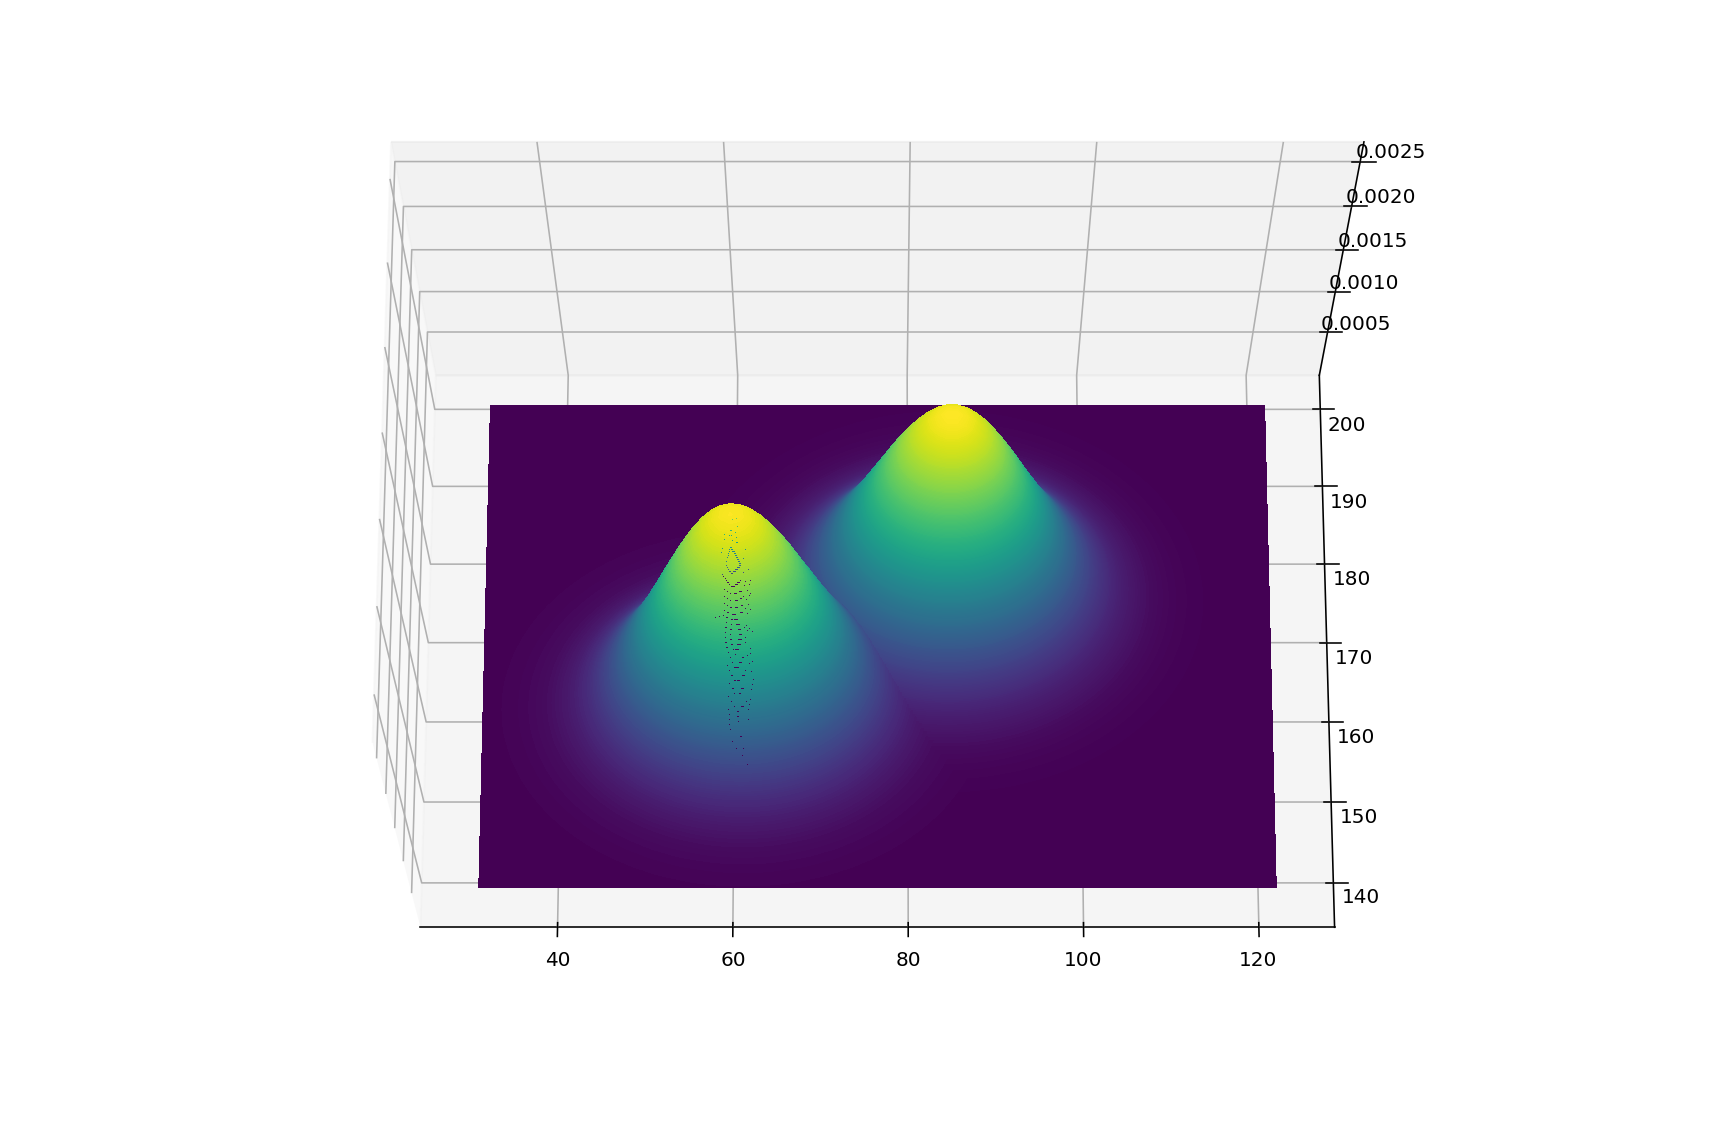

In [36]:
N = 300
X, Y = np.meshgrid(joint_hombres.X, joint_hombres.Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z_H = multivariate_normal.pdf(pos, mean_hombres, cov_hombres*np.identity(2))
Z_M = multivariate_normal.pdf(pos, mean_mujeres, cov_mujeres*np.identity(2))
Z, _ = get_prob_naive(pos)

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
#plt.colorbar(cf, ax=ax)
ax.contourf(X, Y, Z_H, 256)
ax.contourf(X, Y, Z_M, 256)
ax.view_init(70, -90)
plt.show()

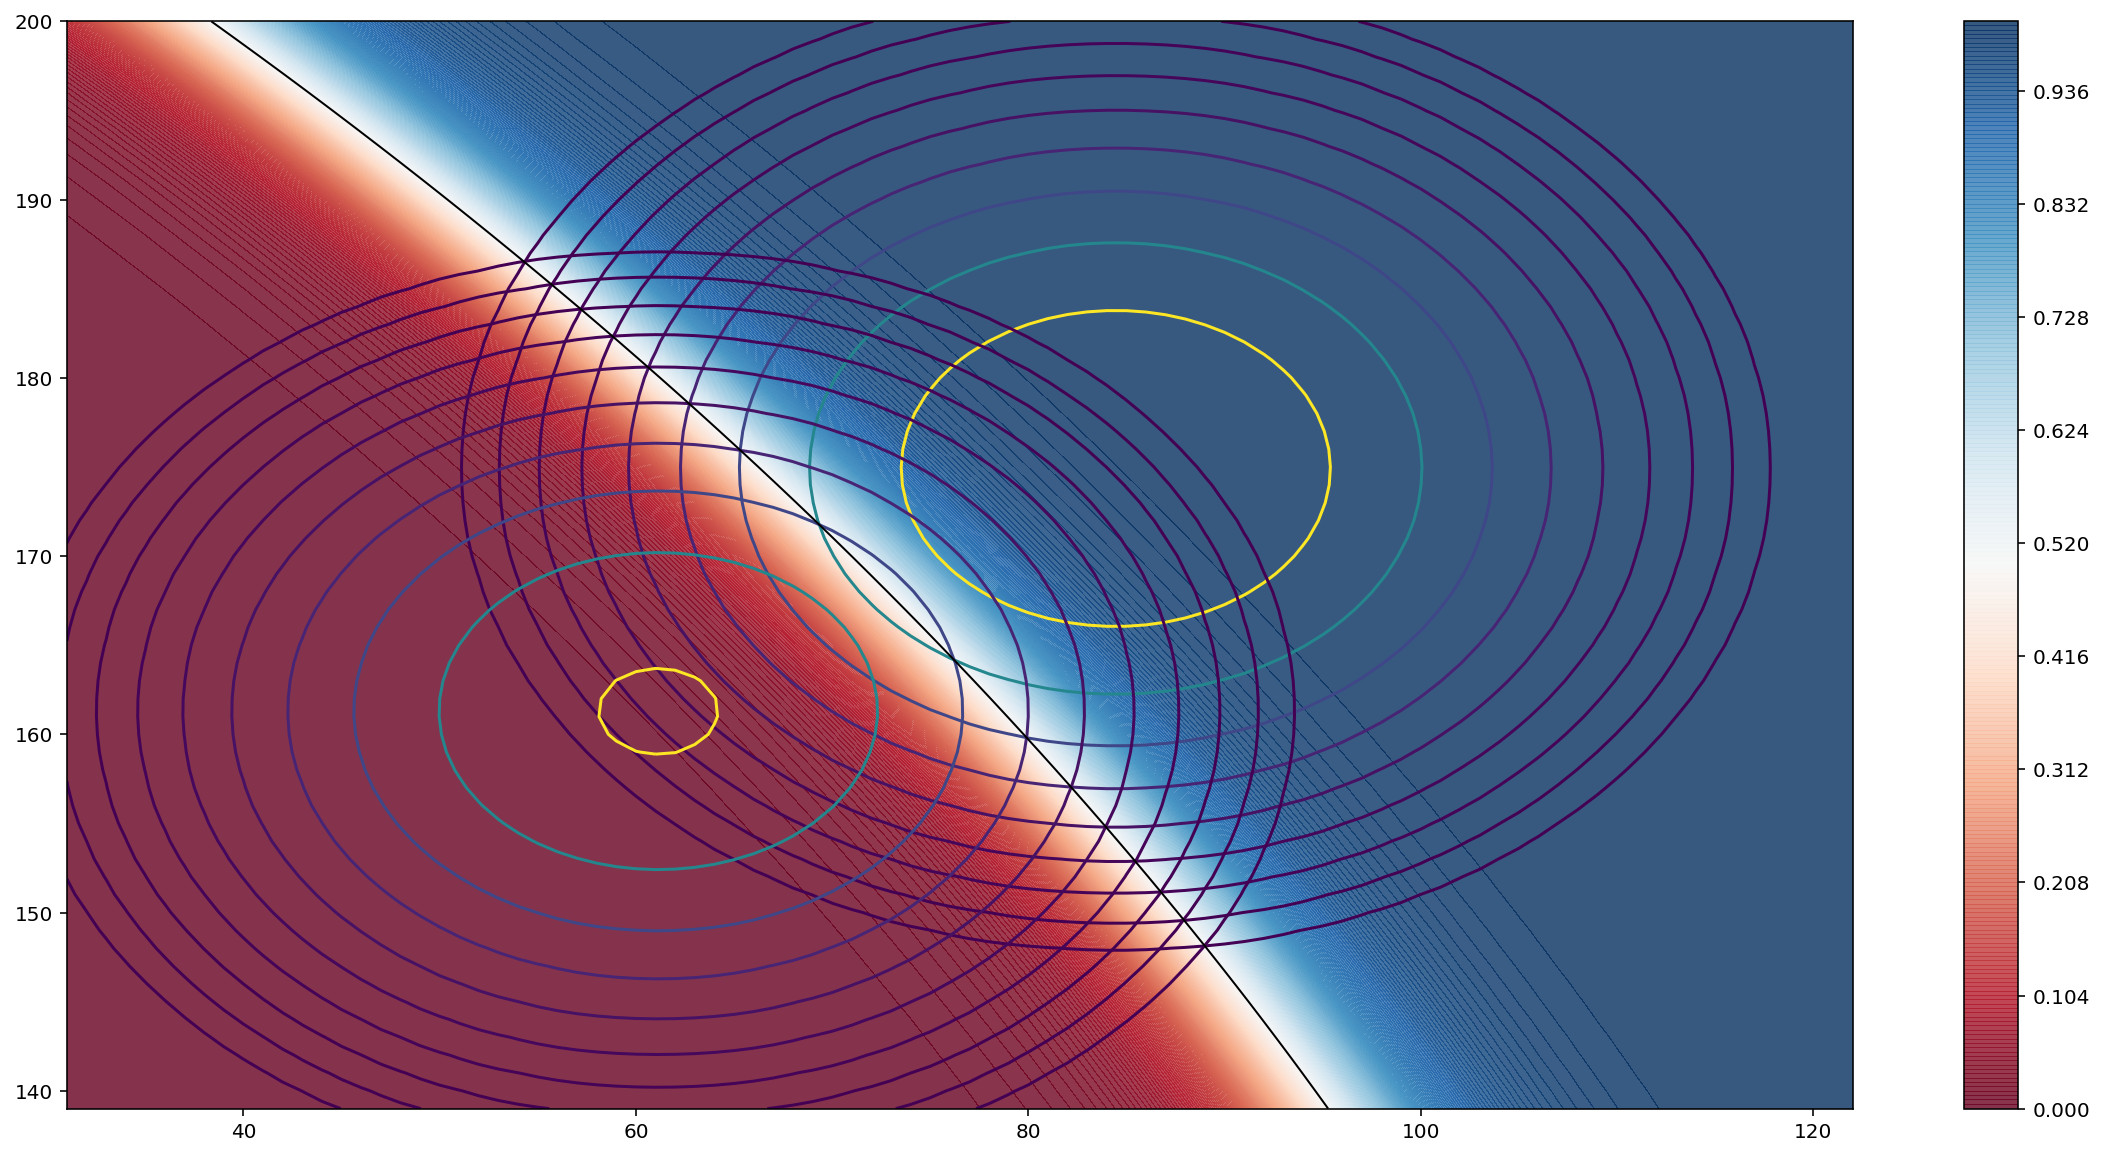

In [37]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,10)/4
ax.contour(X, Y, Z_H, z_levels)
ax.contour(X, Y, Z_M, z_levels)
ax.contour(X, Y, Z, (0.5,), colors='k', linewidths=1)
plt.show()

In [38]:
def get_acc_gauss_naive(data):
    p_class_1, p_class_2 = get_prob_naive(data[['Peso', 'Altura']].values)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(p_class_1)

In [39]:
get_acc_gauss_naive(data)

0.887

In [40]:
get_acc_gauss_naive(test)

0.887